<a href="https://colab.research.google.com/github/aissam-out/Predicting-Heart-Disease/blob/master/XGB_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import resources

In [0]:
# import modules
import matplotlib
import numpy as np
import pandas as pd 
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
matplotlib.use('Agg')
%matplotlib inline

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 3.5MB/s 


In [0]:
# loading the dataset
downloaded_train_v = drive.CreateFile({'id':'********************'}) 
downloaded_train_l = drive.CreateFile({'id':'********************'}) 

downloaded_train_v.GetContentFile('train_values.csv')
downloaded_train_l.GetContentFile('train_labels.csv')

df_train_v = pd.read_csv("train_values.csv")
df_train_l = pd.read_csv("train_labels.csv")

# Data Exploration & preprocessing

## Train Data

In [0]:
# replace strings with numbers
df_train_v['thal'] = df_train_v['thal'].replace({'normal':0,'reversible_defect':1, 'fixed_defect':2})
df_train_v = pd.get_dummies(df_train_v, columns=['slope_of_peak_exercise_st_segment','chest_pain_type','num_major_vessels'])

In [0]:
# Feature engineering 1
df_train_v["added"]=df_train_v['oldpeak_eq_st_depression']/df_train_v['max_heart_rate_achieved']

In [0]:
# drop ID column
df_train_v = df_train_v.drop("patient_id", axis=1)
df_train_l = df_train_l.drop("patient_id", axis=1)

In [0]:
# Feature engineering 2 : extra drops 
df_train_v = df_train_v.drop(["fasting_blood_sugar_gt_120_mg_per_dl",
                              "oldpeak_eq_st_depression",
                              "slope_of_peak_exercise_st_segment_1",
                              "slope_of_peak_exercise_st_segment_3",
                              "chest_pain_type_1",
                              "chest_pain_type_2",
                              "chest_pain_type_3",
                              "num_major_vessels_1",
                              "num_major_vessels_2",
                              "num_major_vessels_3"], 
                             axis=1)

In [0]:
df_train_v.sample()

,thal,resting_blood_pressure,resting_ekg_results,serum_cholesterol_mg_per_dl,sex,age,max_heart_rate_achieved,exercise_induced_angina,slope_of_peak_exercise_st_segment_2,chest_pain_type_4,num_major_vessels_0,added
37,0,124,0,209,0,62,163,0,0,1,1,0.0


In [0]:
pd.DataFrame(df_train_v.columns).T.iloc[:,0:9]

,0,1,2,3,4,5,6,7,8
0,thal,resting_blood_pressure,resting_ekg_results,serum_cholesterol_mg_per_dl,sex,age,max_heart_rate_achieved,exercise_induced_angina,slope_of_peak_exercise_st_segment_2


In [0]:
pd.DataFrame(df_train_v.columns).T.iloc[:,9:14]

,9,10,11
0,chest_pain_type_4,num_major_vessels_0,added


In [0]:
# convert to values
df_train_v = (df_train_v.values).astype('float32')
df_train_v = preprocessing.scale(df_train_v)
df_train_l = df_train_l.values.astype('float32')

In [0]:
df_train_v.shape

(180, 12)

In [0]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(df_train_v, df_train_l, test_size=0.2)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

# convert column-vector to 1d array
y_train = np.ravel(y_train)

x_train shape: (144, 12)
144 train samples


## Indaba Test 

In [0]:
# load the test set
downloaded_test_v = drive.CreateFile({'id':'************'})
downloaded_test_v.GetContentFile('test_values.csv')

df_test_v = pd.read_csv("test_values.csv")
test_indabax = df_test_v.copy()

# preprocess test set
test_indabax['thal'] = test_indabax['thal'].replace({'normal':0,'reversible_defect':1, 'fixed_defect':2})
test_indabax = pd.get_dummies(test_indabax, columns=['slope_of_peak_exercise_st_segment','chest_pain_type','num_major_vessels'])
test_indabax["added"]=test_indabax['oldpeak_eq_st_depression']/test_indabax['max_heart_rate_achieved']
test_indabax = test_indabax.drop("patient_id",axis=1)
test_indabax = test_indabax.drop(["fasting_blood_sugar_gt_120_mg_per_dl",
                                  "oldpeak_eq_st_depression",
                                  "slope_of_peak_exercise_st_segment_1",
                                  "slope_of_peak_exercise_st_segment_3",
                                  "chest_pain_type_1",
                                  "chest_pain_type_2",
                                  "chest_pain_type_3",
                                  "num_major_vessels_1",
                                  "num_major_vessels_2",
                                  "num_major_vessels_3"], 
                                 axis=1)
test_indabax = (test_indabax.values).astype('float32')
test_indabax = preprocessing.scale(test_indabax)

# load submission form
sub_form = drive.CreateFile({'id':'*****************'})
sub_form.GetContentFile('submission_format.csv')

df_sub = pd.read_csv("submission_format.csv")
df_sub_indabax = df_sub.copy()

# Training

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_train_v, df_train_l, test_size=0.2)
y_train = np.ravel(y_train)

In [0]:
folds = 10
param_comb = 100
max_depth = [6]
n_estimators = range(1, 200)

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state=7)

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

model = xgb.XGBClassifier(gamma=0.95, learning_rate=0.1, 
                          min_child_weight=3, subsample=0.8, rate_drop=0.1)

grid_search = GridSearchCV(model, param_grid, scoring='neg_log_loss', n_jobs=-1, cv=skf, verbose=1)

grid_result = grid_search.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

predictions = grid_search.predict_proba(x_test)[:, 1]
print("\n TEST log loss is :", log_loss(y_test, predictions))

Fitting 10 folds for each of 199 candidates, totalling 1990 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed:   15.1s


Best: -0.461006 using {'max_depth': 6, 'n_estimators': 60}
-0.664971 (0.014005) with: {'max_depth': 6, 'n_estimators': 1}
-0.636937 (0.025726) with: {'max_depth': 6, 'n_estimators': 2}
-0.620992 (0.035400) with: {'max_depth': 6, 'n_estimators': 3}
-0.604636 (0.048282) with: {'max_depth': 6, 'n_estimators': 4}
-0.592732 (0.059469) with: {'max_depth': 6, 'n_estimators': 5}
-0.576393 (0.061136) with: {'max_depth': 6, 'n_estimators': 6}
-0.562549 (0.067331) with: {'max_depth': 6, 'n_estimators': 7}
-0.551049 (0.073743) with: {'max_depth': 6, 'n_estimators': 8}
-0.546613 (0.080581) with: {'max_depth': 6, 'n_estimators': 9}
-0.537371 (0.083525) with: {'max_depth': 6, 'n_estimators': 10}
-0.531888 (0.090538) with: {'max_depth': 6, 'n_estimators': 11}
-0.525691 (0.092117) with: {'max_depth': 6, 'n_estimators': 12}
-0.521387 (0.096851) with: {'max_depth': 6, 'n_estimators': 13}
-0.513923 (0.097373) with: {'max_depth': 6, 'n_estimators': 14}
-0.510372 (0.100028) with: {'max_depth': 6, 'n_estimat

[Parallel(n_jobs=-1)]: Done 1990 out of 1990 | elapsed:   46.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


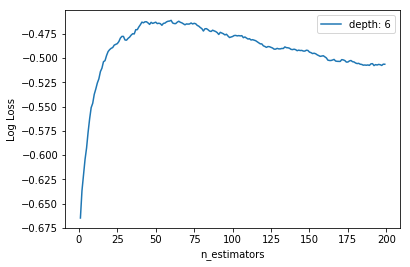

In [0]:
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_max_depth.png')

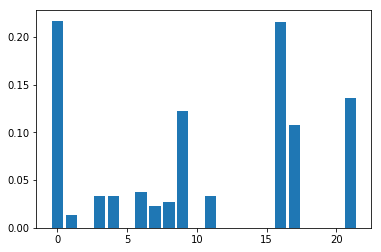

In [0]:
plt.bar(range(len(grid_search.best_estimator_.feature_importances_)), grid_search.best_estimator_.feature_importances_)
plt.show()

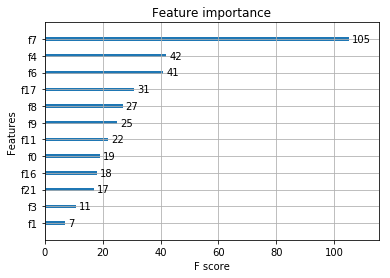

In [0]:
from xgboost import plot_importance

plot_importance(grid_search.best_estimator_)
plt.show()

In [0]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

thresholds = np.sort(grid_search.best_estimator_.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(grid_search.best_estimator_, threshold=thresh, prefit=True)
	select_x_train = selection.transform(x_train)
	# train model
	selection_model = xgb.XGBClassifier(gamma=0, learning_rate=0.05, min_child_weight=3, max_depth = 1, n_estimators=365)
	selection_model.fit(select_x_train, y_train)
	# eval model
	select_x_test = selection.transform(x_test)
	y_pred = selection_model.predict_proba(select_x_test)[:, 1]
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_x_train.shape[1], accuracy*100.0))

Thresh=0.000, n=22, Accuracy: 75.00%
Thresh=0.000, n=22, Accuracy: 75.00%
Thresh=0.000, n=22, Accuracy: 75.00%
Thresh=0.000, n=22, Accuracy: 75.00%
Thresh=0.000, n=22, Accuracy: 75.00%
Thresh=0.000, n=22, Accuracy: 75.00%
Thresh=0.000, n=22, Accuracy: 75.00%
Thresh=0.000, n=22, Accuracy: 75.00%
Thresh=0.000, n=22, Accuracy: 75.00%
Thresh=0.000, n=22, Accuracy: 75.00%
Thresh=0.013, n=12, Accuracy: 75.00%
Thresh=0.023, n=11, Accuracy: 75.00%
Thresh=0.027, n=10, Accuracy: 77.78%
Thresh=0.033, n=9, Accuracy: 80.56%
Thresh=0.033, n=8, Accuracy: 91.67%
Thresh=0.034, n=7, Accuracy: 83.33%
Thresh=0.038, n=6, Accuracy: 86.11%
Thresh=0.108, n=5, Accuracy: 83.33%
Thresh=0.123, n=4, Accuracy: 88.89%
Thresh=0.136, n=3, Accuracy: 83.33%
Thresh=0.215, n=2, Accuracy: 77.78%
Thresh=0.217, n=1, Accuracy: 80.56%


# Useful functions

In [0]:
global_evaluation = {}

def indabax_model(test_num):
  x_train, x_test, y_train, y_test = train_test_split(df_train_v, df_train_l, test_size=0.2)
  y_train = np.ravel(y_train)
  
  model = xgb.XGBClassifier(min_child_weight= 3, 
                            max_depth= 2, 
                            learning_rate= 0.1, 
                            gamma= 9, 
                            colsample_bytree= 0.8, 
                            subsample=0.5, 
                            n_estimators=50000, 
                            objective='binary:logistic', 
                            silent=True, 
                            nthread=1)

  model.fit(x_train, y_train)

  predictions = model.predict_proba(x_test)[:, 1]
  loss = log_loss(y_test, predictions)
  
  global_evaluation.update({"model_%d" %test_num : [loss.round(4)]})

  print("log loss of test %d is : %.4f" %(test_num, loss))
  
  return model

def prep_results(model, file):
  predictions_indabax = model.predict_proba(test_indabax)
  results = pd.DataFrame(predictions_indabax)
  df_sub_indabax["heart_disease_present"] = results
  df_sub_indabax.to_csv(file, header=True, index=False)
  
  return df_sub_indabax

def agregation_model(file, test_num):
  model = indabax_model(test_num)
  df_sub_indabax = prep_results(model, file)
  
  return model

def validation_test(model_name):
  loaded_model = joblib.load(model_name)
  validation_pred = loaded_model.predict_proba(df_VALIDATION_v)[:, 1]
  validation_loss = log_loss(np.ravel(df_VALIDATION_l), validation_pred)
  
  print("validation log loss is :", validation_loss)

# Save results

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls

# Multi tests

In [0]:
for i in range(1,50):
  model = agregation_model("multi_%d.csv" %i, i)
  joblib.dump(model, "model_%d.sav" %i)

log loss of test 1 is : 0.3485
log loss of test 2 is : 0.3644
log loss of test 3 is : 0.5898
log loss of test 4 is : 0.4486
log loss of test 5 is : 0.4702
log loss of test 6 is : 0.4931
log loss of test 7 is : 0.5122
log loss of test 8 is : 0.5214
log loss of test 9 is : 0.4123
log loss of test 10 is : 0.6202
log loss of test 11 is : 0.3525
log loss of test 12 is : 0.5107
log loss of test 13 is : 0.3768
log loss of test 14 is : 0.3948
log loss of test 15 is : 0.2938
log loss of test 16 is : 0.4820
log loss of test 17 is : 0.5380
log loss of test 18 is : 0.3879
log loss of test 19 is : 0.4326
log loss of test 20 is : 0.4463
log loss of test 21 is : 0.4303
log loss of test 22 is : 0.3369
log loss of test 23 is : 0.4731
log loss of test 24 is : 0.4012
log loss of test 25 is : 0.4555
log loss of test 26 is : 0.3382
log loss of test 27 is : 0.4633
log loss of test 28 is : 0.4634
log loss of test 29 is : 0.4449
log loss of test 30 is : 0.3959
log loss of test 31 is : 0.4074
log loss of test 

#  Copy to Drive

In [0]:
%cp multi_22.csv gdrive/'My Drive'/'Colab Notebooks'/indabax

# Evaluation

In [0]:
global_evaluation = pd.DataFrame.from_dict(global_evaluation, orient='index',columns=['Log loss'])
global_evaluation.sort_values(by=['Log loss']).head()

,Log loss
model_15,0.2938
model_36,0.3176
model_22,0.3369
model_26,0.3382
model_1,0.3485


In [0]:
mean = pd.DataFrame.from_dict(global_evaluation.mean(axis = 0)).T
mean.rename(index={0:'mean'}, inplace=True)
mean

,Log loss
mean,0.43859


# Validation tests

In [0]:
for i in global_evaluation.sort_values(by=['Log loss']).head().index :
  validation_test(i +".sav")

validation log loss is : 0.37998802959918976
validation log loss is : 0.38151824846863747
validation log loss is : 0.3253543958067894
validation log loss is : 0.3532919742166996
validation log loss is : 0.32570723369717597


# LAB

In [0]:
model_lab = agregation_model("LAB.csv", 99)

log loss of test 99 is : 0.4427


In [0]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

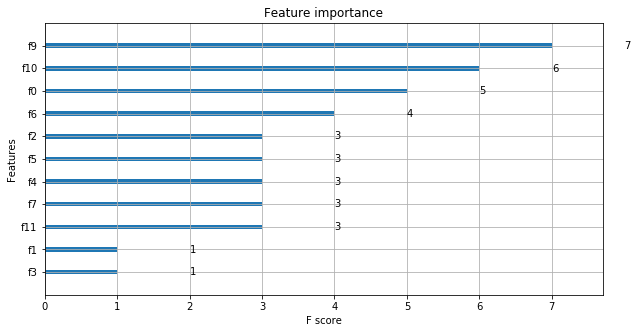

In [0]:
plot_features(model_lab, (10,5))

In [0]:
model_lab.feature_importances_

array([0.1198756 , 0.08122625, 0.08518069, 0.08386566, 0.09239529,
       0.06791864, 0.09586107, 0.08473256, 0.        , 0.09432235,
       0.09223466, 0.10238716], dtype=float32)